In [1]:
import numpy as np
import h5py
import torch
from torch import nn
import numpy as np
import csv
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from nn import *
from sklearn import datasets
from sklearn.model_selection import train_test_split
import torch.nn.init as init
import random

In [2]:
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Split first!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [25]:
class NeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        torch.manual_seed(42)
        random.seed(42)
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 15),
            nn.ReLU(),
            nn.Linear(15, 3)
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
    def _initialize_weights(self):
        # Use NumPy to generate random numbers for weight initialization
        for layer in self.linear_relu_stack:
            if isinstance(layer, nn.Linear):
                # Use NumPy to generate random values for weight initialization
                weight_init = np.random.uniform(0, 1, size=layer.weight.shape)
                bias_init = np.ones_like(layer.bias.detach())  # Detach bias from computation graph

                # Assign the NumPy-generated weights to PyTorch layers
                layer.weight.data = torch.tensor(weight_init, dtype=torch.float32)
                layer.bias.data = torch.tensor(bias_init, dtype=torch.float32)
    
def train(X, y, model, learning_rate, num_epochs, loss_fn, X_test, y_test, validation=False):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    model.train()
    torch.manual_seed(42)

    for epoch in range(num_epochs):
        
        # Forward pass
        preds = model(X)

        # Compute loss
        loss = loss_fn(preds, y)
        
        # Backward pass
        loss.backward()
        
        # Print loss after each epoch
        if (epoch + 1) % 5 == 0:  # Print every 10 epochs (adjust as needed)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


        # Update model parameters
        optimizer.step()
        
        # Zero gradients for the next step
        optimizer.zero_grad()

        if validation:      
            # Validation step
            model.eval()  # Switch to evaluation mode (disables dropout, batch norm, etc.)
            with torch.no_grad():  # Disable gradient calculation for validation to save memory and computation
                val_preds = model(X_test)
                val_loss = loss_fn(val_preds, y_test)
            
            # Print validation loss after each epoch
            # if (epoch + 1) % 5 == 0:  # Print every 10 epochs (adjust as needed)
            #     print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss.item():.4f}")
            
        model.train() 

    print("Training complete.")

def test(X_test, y_test, model, loss_fn):
    model.eval()  # Set model to evaluation mode (disables dropout, batch norm, etc.)
    
    # Forward pass
    with torch.no_grad():  # No gradient tracking needed for inference
        preds = model(X_test)
    # Convert predictions to class labels (for classification)
    _, predicted = torch.max(preds, 1)
    
    # Calculate accuracy
    correct = (predicted == y_test).sum().item()
    total = y_test.size(0)
    accuracy = 100 * correct / total
    
    # Calculate cross-entropy loss
    loss = loss_fn(preds, y_test)
                                                                
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test Loss (Cross-Entropy): {loss:.4f}")
    return predicted

In [4]:
print(y_test_tensor.shape)

torch.Size([30])


In [5]:
model_torch = NeuralNetwork()
train(X_train_tensor, y_train_tensor, model_torch, 0.001, 1000, nn.CrossEntropyLoss(), X_test_tensor, y_test_tensor, False)

Epoch [5/1000], Loss: 4.2763
Epoch [10/1000], Loss: 4.0672
Epoch [15/1000], Loss: 3.8610
Epoch [20/1000], Loss: 3.6583
Epoch [25/1000], Loss: 3.4596
Epoch [30/1000], Loss: 3.2656
Epoch [35/1000], Loss: 3.0769
Epoch [40/1000], Loss: 2.8945
Epoch [45/1000], Loss: 2.7193
Epoch [50/1000], Loss: 2.5524
Epoch [55/1000], Loss: 2.3948
Epoch [60/1000], Loss: 2.2472
Epoch [65/1000], Loss: 2.1104
Epoch [70/1000], Loss: 1.9844
Epoch [75/1000], Loss: 1.8689
Epoch [80/1000], Loss: 1.7636
Epoch [85/1000], Loss: 1.6677
Epoch [90/1000], Loss: 1.5807
Epoch [95/1000], Loss: 1.5019
Epoch [100/1000], Loss: 1.4310
Epoch [105/1000], Loss: 1.3676
Epoch [110/1000], Loss: 1.3116
Epoch [115/1000], Loss: 1.2625
Epoch [120/1000], Loss: 1.2202
Epoch [125/1000], Loss: 1.1841
Epoch [130/1000], Loss: 1.1536
Epoch [135/1000], Loss: 1.1279
Epoch [140/1000], Loss: 1.1065
Epoch [145/1000], Loss: 1.0885
Epoch [150/1000], Loss: 1.0735
Epoch [155/1000], Loss: 1.0607
Epoch [160/1000], Loss: 1.0499
Epoch [165/1000], Loss: 1.04

In [6]:
preds = test(X_test_tensor, y_test_tensor, model_torch, nn.CrossEntropyLoss()).detach().numpy()
print(np.mean(preds == y_test))

Test Accuracy: 83.33%
Test Loss (Cross-Entropy): 0.6653
0.8333333333333334


In [7]:
my_model = ANNClassification([20], ["relu"])
my_model.fit(X_train, y_train, 0.001, 1000)

In [8]:
preds2 = np.argmax(my_model.predict(X_test_tensor), axis=1)
print(np.mean(preds2 == y_test))

0.7666666666666667


In [9]:
print(np.mean(preds2 == preds))

0.9333333333333333


In [33]:
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)

# Optionally, for CUDA (if you're using GPU)
torch.cuda.manual_seed_all(seed_value)

torch_results = []
torch_preds = []

my_results = []
my_preds = []

similarity = []
epochs = range(10, 750, 10)

for eps in epochs:
    model_torch = NeuralNetwork()
    train(X_train_tensor, y_train_tensor, model_torch, 0.01, eps, nn.CrossEntropyLoss(), X_test_tensor, y_test_tensor, False)
    preds = test(X_test_tensor, y_test_tensor, model_torch, nn.CrossEntropyLoss()).detach().numpy()
    torch_preds.append(preds)
    torch_results.append(np.mean(preds == y_test))
    my_model = ANNClassification([15], ["relu"])
    my_model.fit(X_train, y_train, 0.01, eps)
    preds2 = np.argmax(my_model.predict(X_test), axis=1)
    my_preds.append(preds2)
    my_results.append(np.mean(preds2 == y_test))

    similarity.append(np.mean(preds2 == preds))
    

Epoch [5/10], Loss: 1.2706
Epoch [10/10], Loss: 1.0961
Training complete.
Test Accuracy: 36.67%
Test Loss (Cross-Entropy): 1.0376
Epoch [5/20], Loss: 1.2706
Epoch [10/20], Loss: 1.0961
Epoch [15/20], Loss: 1.0366
Epoch [20/20], Loss: 1.0028
Training complete.
Test Accuracy: 36.67%
Test Loss (Cross-Entropy): 0.9363
Epoch [5/30], Loss: 1.2706
Epoch [10/30], Loss: 1.0961
Epoch [15/30], Loss: 1.0366
Epoch [20/30], Loss: 1.0028
Epoch [25/30], Loss: 0.9762
Epoch [30/30], Loss: 0.9529
Training complete.
Test Accuracy: 46.67%
Test Loss (Cross-Entropy): 0.8885
Epoch [5/40], Loss: 1.2706
Epoch [10/40], Loss: 1.0961
Epoch [15/40], Loss: 1.0366
Epoch [20/40], Loss: 1.0028
Epoch [25/40], Loss: 0.9762
Epoch [30/40], Loss: 0.9529
Epoch [35/40], Loss: 0.9317
Epoch [40/40], Loss: 0.9119
Training complete.
Test Accuracy: 56.67%
Test Loss (Cross-Entropy): 0.8509
Epoch [5/50], Loss: 1.2706
Epoch [10/50], Loss: 1.0961
Epoch [15/50], Loss: 1.0366
Epoch [20/50], Loss: 1.0028
Epoch [25/50], Loss: 0.9762
Epoch

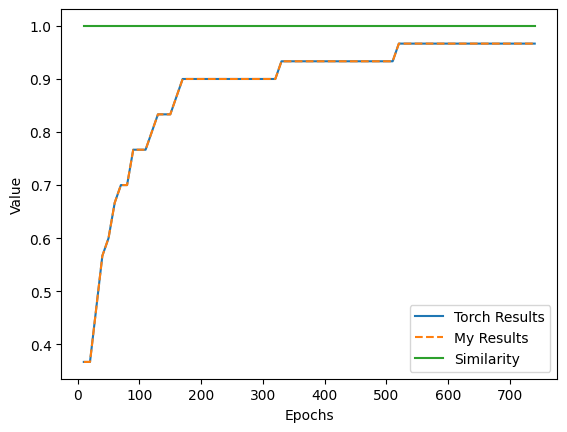

In [34]:
plt.plot(epochs, torch_results, label="Torch Results")
plt.plot(epochs, my_results, linestyle="--", alpha=1, label="My Results")
plt.plot(epochs, similarity, label="Similarity")

# Adding the legend
plt.legend()

# Optionally, you can also add titles and labels
plt.xlabel('Epochs')
plt.ylabel('Value')

# Display the plot
plt.savefig("Classification comparison.pdf", bbox_inches="tight")

In [46]:
boston = datasets.fetch_california_housing()

# Extract features (X) and target variable (y)
X = boston.data
y = boston.target


# Split into training and test sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features (important for neural networks)
scaler = StandardScaler()
X_train_reg = scaler.fit_transform(X_train_reg)
X_test_reg = scaler.transform(X_test_reg)

X_train_reg_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_reg_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_reg_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_reg_tensor = torch.tensor(y_test, dtype=torch.float32)
print(X_train_reg_tensor.shape)

torch.Size([120, 4])


In [40]:
class RegressionNeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        torch.manual_seed(42)
        random.seed(42)
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 15),
            nn.ReLU(),
            nn.Linear(15, 1)
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
    def _initialize_weights(self):
        # Use NumPy to generate random numbers for weight initialization
        for layer in self.linear_relu_stack:
            if isinstance(layer, nn.Linear):
                # Use NumPy to generate random values for weight initialization
                weight_init = np.random.uniform(0, 1, size=layer.weight.shape)
                bias_init = np.ones_like(layer.bias.detach())  # Detach bias from computation graph

                # Assign the NumPy-generated weights to PyTorch layers
                layer.weight.data = torch.tensor(weight_init, dtype=torch.float32)
                layer.bias.data = torch.tensor(bias_init, dtype=torch.float32)

In [ ]:
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)

# Optionally, for CUDA (if you're using GPU)
torch.cuda.manual_seed_all(seed_value)

torch_results = []
torch_preds = []

my_results = []
my_preds = []

similarity = []
epochs = range(10, 750, 10)

for eps in epochs:
    model_torch = RegressionNeuralNetwork()
    train(X_train_reg_tensor, y_train_reg_tensor, model_torch, 0.01, eps, nn.MSELoss(), X_test_reg_tensor, y_test_reg_tensor, False)
    preds = test(X_test_reg_tensor, y_test_reg_tensor, model_torch, nn.MSELoss()).detach().numpy()
    torch_preds.append(preds)
    torch_results.append(np.mean((preds - y_test_reg) ** 2))
    my_model = ANNRegression([15], ["relu"])
    my_model.fit(X_train_reg, y_train_reg, 0.01, eps)
    preds2 = my_model.predict(X_test_reg)
    my_preds.append(preds2)
    my_results.append(np.mean((preds2 - y_test_reg) ** 2))

    similarity.append(np.mean((preds2 - preds) ** 2))

Epoch [5/10], Loss: 0.7011
Epoch [10/10], Loss: 0.6905
Training complete.
Test Accuracy: 33.33%
Test Loss (Cross-Entropy): 0.7245


c:\Users\matej\miniconda3\envs\MLDS_HW1\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([120])) that is different to the input size (torch.Size([120, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\matej\miniconda3\envs\MLDS_HW1\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'